# Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import numpy as np
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,precision_score,roc_auc_score,recall_score
from scipy.stats import uniform, truncnorm, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import random
import lightgbm as lgb

import gensim

import warnings
warnings.filterwarnings('always')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Gathering

In [ ]:
# %cd /content/drive/MyDrive/oriserve
# !unzip Ori_Assignment.zip

In [ ]:
! mkdir /content/Ori_Assignment
! cp /content/drive/MyDrive/oriserve/Ori_Assignment/* /content/Ori_Assignment

In [ ]:
%cd Ori_Assignment/

/content/Ori_Assignment


## Read Data

In [ ]:
data = pd.read_excel('data_set.xlsx')

In [ ]:
data.sample(5)

,intent,message
586,serviceCost,kya iss bike ka maintainance mehenga hai
471,newDesign,iss bike ki design janna chahta hu mei
14,airCooled,is it oil cooled
638,topSpeed,how fast is ducati
11,airCooled,Why not air cooled


## Data Analysis

### Understanding the labels

In [ ]:
print(f"Number of distinct classes:{data['intent'].nunique()}")
print("--"*30)
print(f"Distribution of classes:{data['intent'].value_counts()}")

Number of distinct classes:55
------------------------------------------------------------
Distribution of classes:newDesign                     35
ducati                        32
Apparel                       26
complaints                    26
safetyMeasuresCovid           26
instrumentCluster             24
tbtNavigation                 23
launchSignup                  23
tubelessTyres                 22
fuelCapacity                  22
bookTestRide                  22
ducatiAvailabilityDelivery    22
ducatiFinance                 22
serviceCost                   21
bookingAmount                 21
locateDealer                  20
comfort                       20
braking                       19
faceFilters                   18
downloadWallpapers            18
rsa                           18
miy                           18
ducatiColours                 18
bs6                           17
power                         17
engine                        16
ducatiPrice                

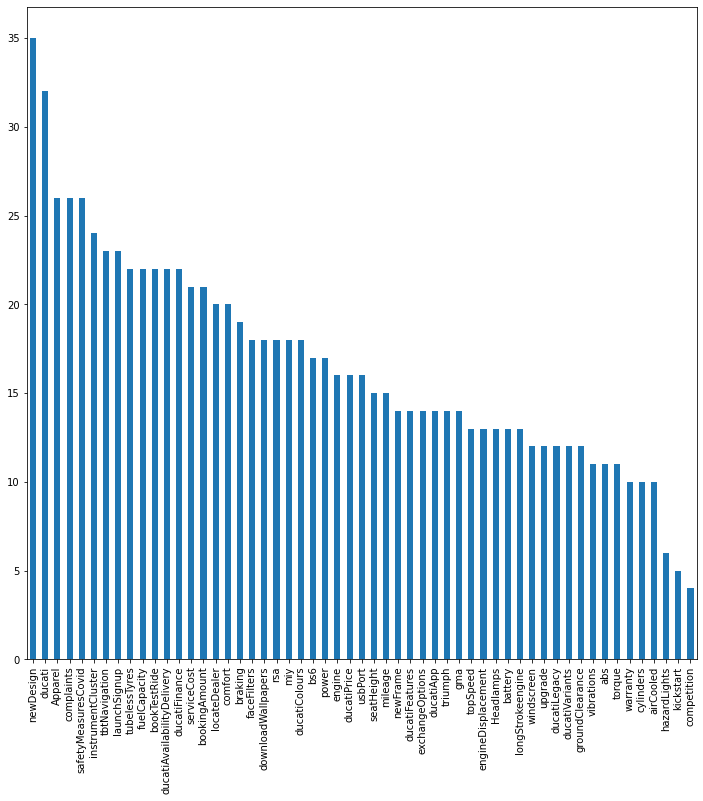

In [ ]:
plt.figure(figsize=(12,12))
data['intent'].value_counts().plot(kind='bar')

We observe that the label distribution is not balanaced, as 'competition' and some few classes have very few data samples.

### Understanding the data

In [ ]:
data.sample(10,random_state=3)

,intent,message
709,vibrations,there is a lot of vibration in ducati
466,newDesign,Does it look classy or sporty
557,rsa,road side assistance
227,gma,tinted flyscreen milegi mujhe
83,bs6,Will the motorcycle add to the air pollution
427,ducatiVariants,show me the variants in ducati
606,tbtNavigation,How to use TBT navigation
822,safetyMeasuresCovid,covid protocols follow hori hai
804,safetyMeasuresCovid,are dealerships safe
58,braking,disc brakes in ducati


we observe that some or the other words from the message replicates in the intent.
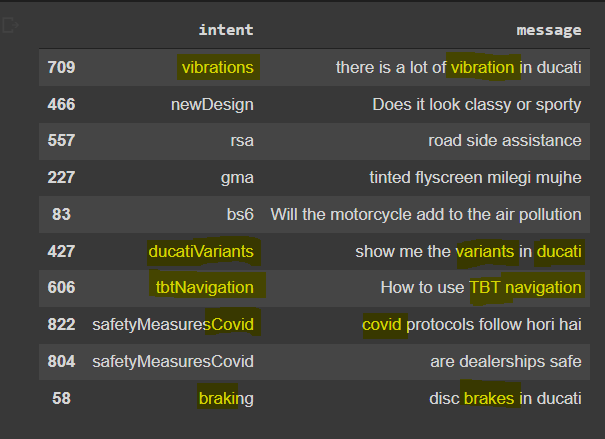

Also we see that the messages are in Hinglish (Hindi+English), Thus making it difficult to use the default existing pretraind models

In [ ]:
def wordCloudPlot(data,label):
    '''
    data : the dataframe with intent and message columns
    label : the class of dataframe wrt which we want to plot

    Returns : wordcloud
    '''

    list_of_sent = data[data['intent'] == label]['message']
    comment_words = ''
    stopwords = set(STOPWORDS)

    for val in list_of_sent:
      tokens = val.split()
      comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
            background_color ='black',
            stopwords = stopwords,
            min_font_size = 10).generate(comment_words)
    return wordcloud

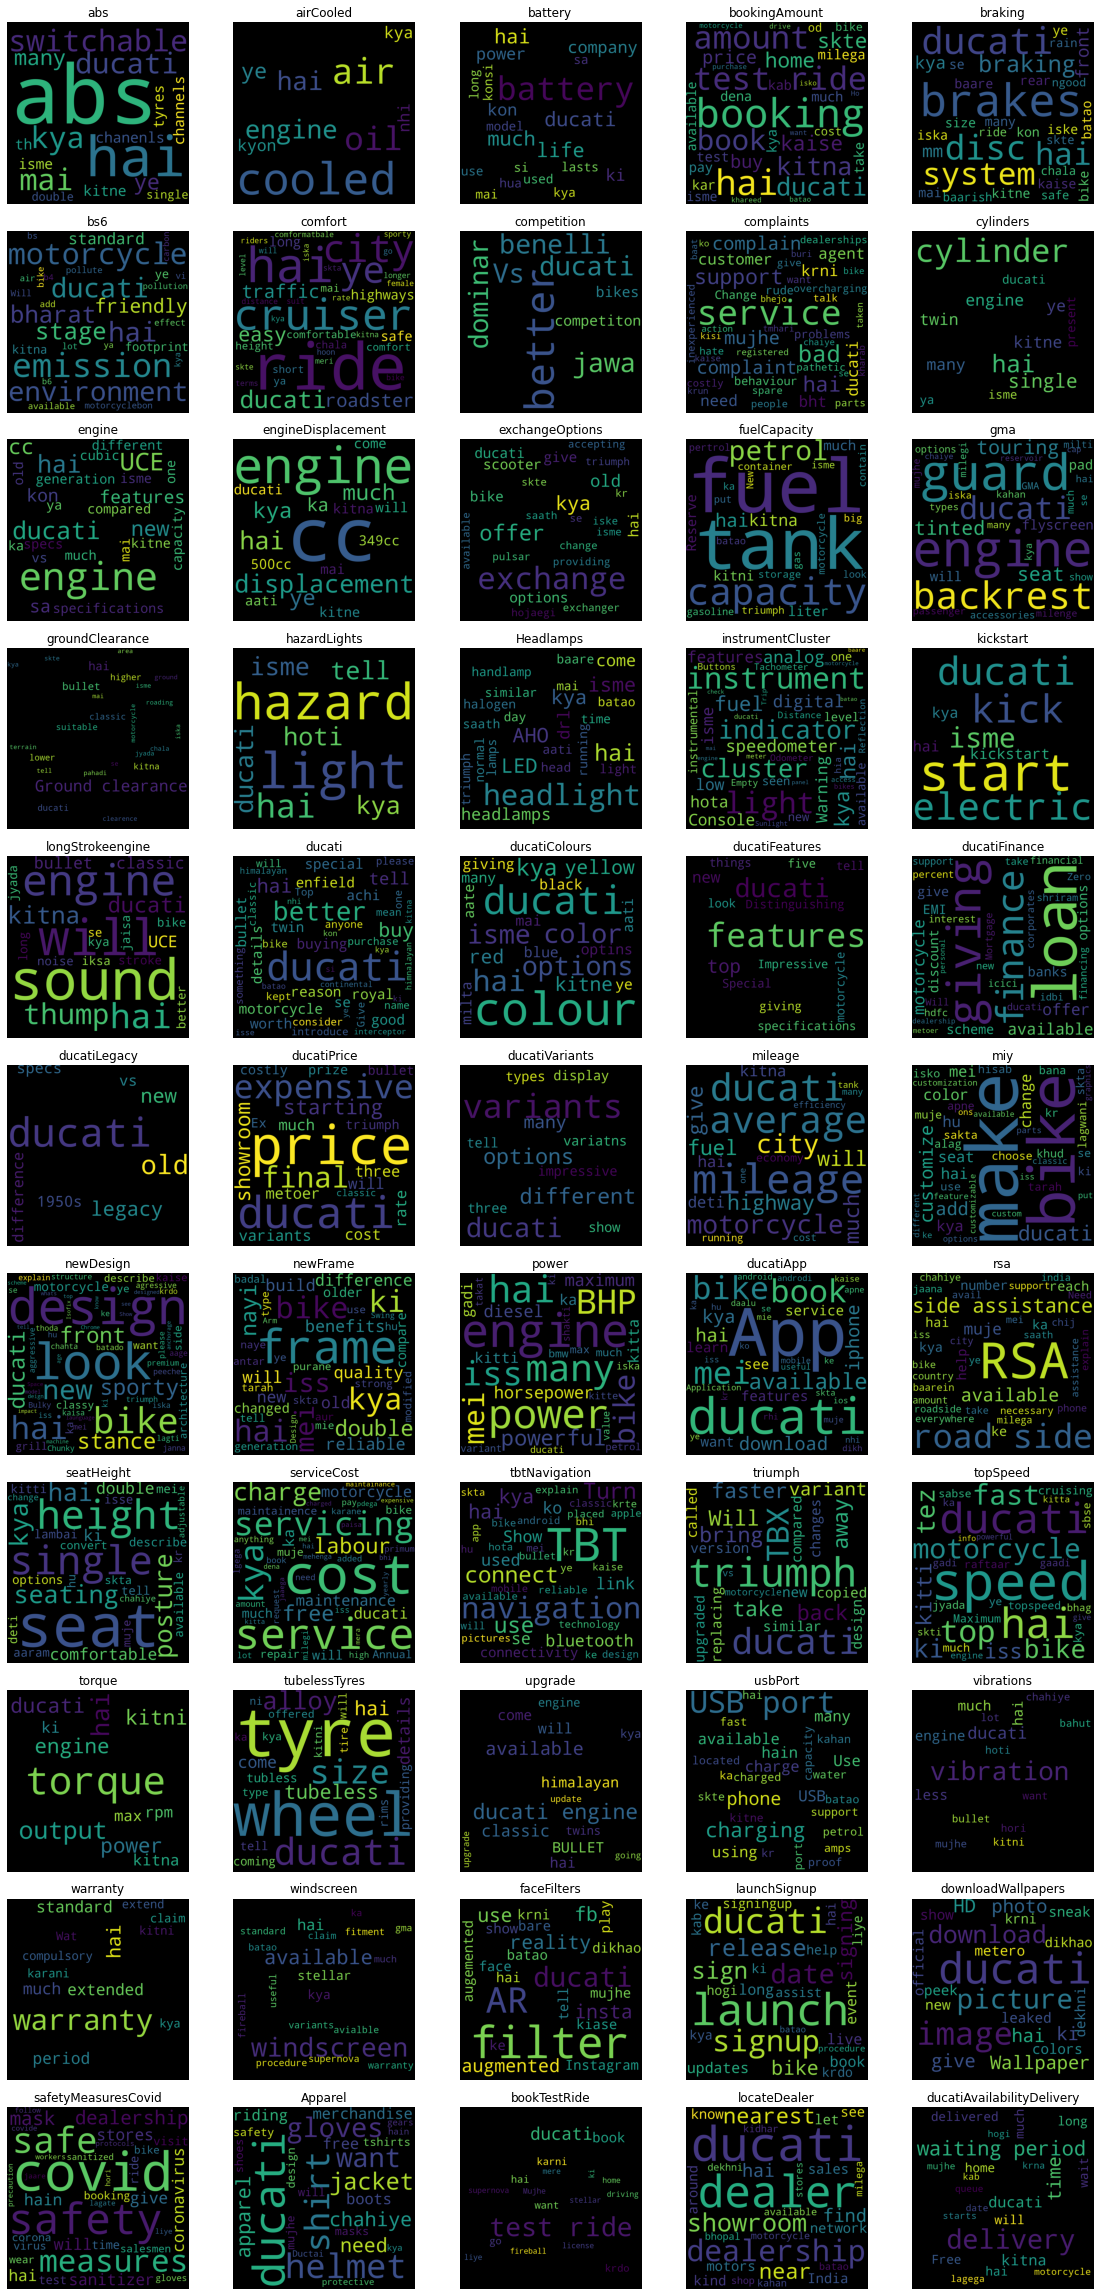

In [ ]:
plt.figure(figsize=(16,32))
j=0
for i,l in enumerate(list(data['intent'].unique())):
    wordcloud = wordCloudPlot(data,l)
    plt.subplot(11,5,i+1)
    plt.title(l)
    plt.imshow(wordcloud)
    plt.axis("off")
plt.tight_layout()
plt.show()

### External Data 

In [ ]:
# # !wget https://amitavadas.com/ICON2016/FB_HI_EN_FN.txt
# # !wget https://amitavadas.com/ICON2016/TWT_HI_EN_FN.txt
# # !wget https://amitavadas.com/ICON2016/WA_HI_EN_FN.txt

# f = open(os.path.join('', 'FB_HI_EN_FN.txt'),  encoding = "utf-8")
# for line in f:
#     try:
#       value = line.split()[0]
#     except:
#       pass
#     if '@' in value:
#         flag = True
#     else:
#         flag = False
#         print(value)
#     if i == 50:
#       break

But we are not using any external data,as those are not relatable to the context, but as an idea we can use product description documents in hindi-english mixed coded, and use the context corpus to train a better model as we have less sample of data

## Preprocessing

### Data Cleaning

On Observation question mark and ... and similar few kind of extra punctuations are added, as part of preprocessing we can remove these and generate clean sentenses

In [ ]:
def preprocess(text):
    '''
    text: raw sentence
       Removing Punctuations
        making lower case 
    Returns : clean text
    '''
    stopwords = set(STOPWORDS)
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = cleaned_text.lower() 
    te = []
    for word in cleaned_text.split(' '):
      if word not in stopwords:
        te.append(word)
    cleaned_text = ' '.join(te)
    return cleaned_text

Examples:

* 689 :                      twins m ducati engine same hai?
* 535 :  kya ducati app iphone or androdi mei available...

Not removing word length less than 2 because 'vs' would be primary feature in predicting the class competition

In [ ]:
data['message'] = data['message'].apply(lambda x:preprocess(x))

In [ ]:
data.sample(3)

,intent,message
869,bookTestRide,test ride karni hai
696,usbPort,use usb port
896,ducatiAvailabilityDelivery,much queue delivery


### Splitting the data

As mentioned in the problem constraint :

* Train to test split ratio must be 60:40.

In [ ]:
X = data['message']
y = data['intent']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y,random_state=32)

In [ ]:
print(f"Shape for train data X: {X_train.shape}")
print(f"Shape for test data X: {X_test.shape}")
print(f"Shape for train data Y: {y_train.shape}")
print(f"Shape for test data Y: {y_test.shape}")

Shape for train data X: (549,)
Shape for test data X: (366,)
Shape for train data Y: (549,)
Shape for test data Y: (366,)


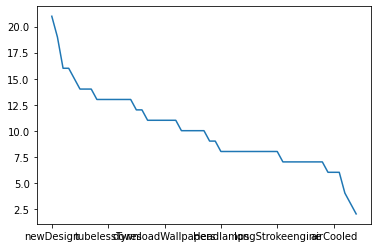

In [ ]:
#Class Distribution in train_data
y_train.value_counts().plot()

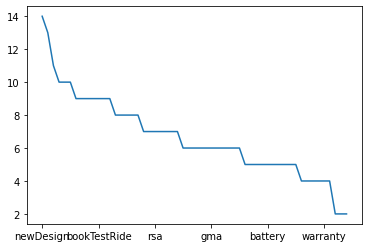

In [ ]:
#Class Distribution in test_data
y_test.value_counts().plot()

### Augmentation in train dataset

In [ ]:
def OverSamplingData(label,data,max_samples,length_of_sentence='constant'):
    '''
    label : the Class label we want to augment
    max_samples: maximum samples we want to create for label class
    length_of_sentence : length of each sentence,
                         {'constant': all sentence will be of same length
                          'variable': all sentence will have different length which 
                                      will be less than the unique words}
    '''
    global vocab

     # Creating Vocabulary
    vocab = []
    for sent in list(data[data['intent'] == label]['message']):
        for words in sent.split():
            vocab.append(words)
    vocab = list(set(vocab))

    if length_of_sentence == 'constant':
        length_of_sentence = 2
    elif length_of_sentence == 'variable':
        length_of_sentence = np.random.randint(2,len(vocab))   

    # Augmentation
    newSentences=[]
    labels=[]
    for sample in range(max_samples):
        random.shuffle(vocab)
        sampleSent = ' '.join(vocab[:length_of_sentence])
        newSentences.append(sampleSent)
        labels.append(label)

    newData = pd.DataFrame()
    newData['message'] = newSentences
    newData['intent'] = labels
    return newData

In [ ]:
def BalancedData(data):
    """
    data: data we want to balance
    prints the threshold value 
    
    Returns a new data frame
    """
    # threshold = int(np.median(list(dict(data['intent'].value_counts()).values())))
    label_count_dictionary = dict(data['intent'].value_counts())
    threshold = int(max(list(label_count_dictionary.values())))-1
    # threshold = 21
    print(f"On average we have {threshold} samples for each class")
    overSamplingLabels = []
    for k,v in dict(data['intent'].value_counts()).items():
        if v < threshold:
          overSamplingLabels.append(k)

    list_of_df=[]
    for l in overSamplingLabels:
        no_of_samples = int(threshold - label_count_dictionary[l] ) 
        DF = OverSamplingData(data=data,label=l,max_samples = no_of_samples ,length_of_sentence='variable')
        list_of_df.append(DF)
    dataNew = pd.concat(list_of_df)
    return dataNew

In [ ]:
train_data = pd.DataFrame()
train_data['message'] = list(X_train)
train_data['intent'] = list(y_train)
train_data.sample(3)

,message,intent
61,explain tbt design,tbtNavigation
309,twin ducati kon si better hai,ducati
16,long stroke engine,longStrokeengine


On average we have 20 samples for each class


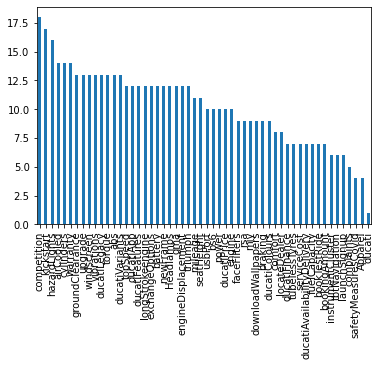

In [ ]:
augmented_data = BalancedData(train_data)
augmented_data['intent'].value_counts().plot(kind='bar')

In [ ]:
new_train_data = pd.concat([train_data,augmented_data])
new_train_data.sample(3)

,message,intent
12,variants variatns show different,ducatiVariants
5,hai emission ye kitna friendly environment car...,bs6
6,will options giving take give financial financ...,ducatiFinance


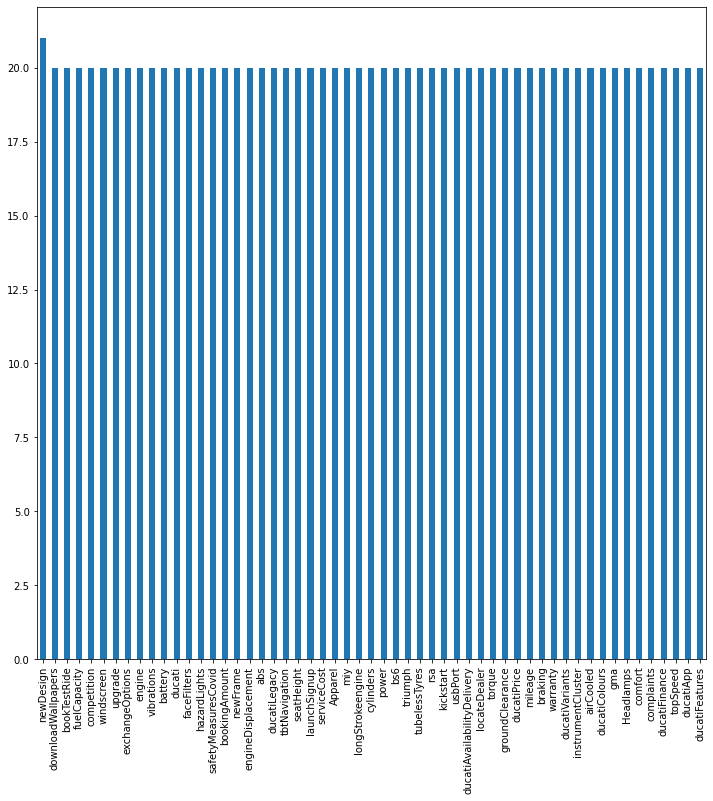

In [ ]:
plt.figure(figsize=(12,12))
new_train_data['intent'].value_counts().plot(kind='bar')

In [ ]:
X_train_augmented = new_train_data['message']
y_train_augmented = new_train_data['intent']

# Machine Learing Approach

## Performance metric plot preperation

In [ ]:
def metrics_plot(model,true,to_pred,X_test,augmentation = False):
    """
    To plot the metrics and result of performance of model
    INPUT - 
          model: Model Selected
          true : Groud truth Values
          to_pred: Values to predict
          X_test : pre-vectorized values
    RETURNS -
          Perfomance metric (type{dictionary})
    """

    if augmentation == True:
        typ = 'macro'
    else:
        typ = 'micro'

    accuracy = model.score(to_pred,true)
    
    f1 = f1_score(true,model.predict(to_pred),average=typ,labels=np.unique(model.predict(to_pred)))
    precision = precision_score(true,model.predict(to_pred),average=typ)
    rec = recall_score(true,model.predict(to_pred),average=typ)
    auc = roc_auc_score(true,model.predict_proba(to_pred),multi_class='ovr')

    metrics = {}
    metrics['accuracy'] = accuracy
    metrics['F1_score'] = f1
    metrics['precision'] = precision
    metrics['recall'] = rec
    metrics['auc'] = auc

    print("="*20,"Model metrics","="*20)
    print(pd.DataFrame([metrics]))
    
    print("\n")
    print("="*20,"Example output","="*20)
    pred_top_10 =[]
    for i in range(10):
        pred_top_10.append(model.predict(to_pred[i])[0])
    print(pd.DataFrame(list(pred_top_10),list(X_test[:10]),columns=['Predicted']))

    print("\n")
    print("="*20,"Confusion Matrix","="*20)
    plt.figure(figsize=(17,17))
    sns.heatmap(confusion_matrix(true,model.predict(to_pred)),annot=True,cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return metrics

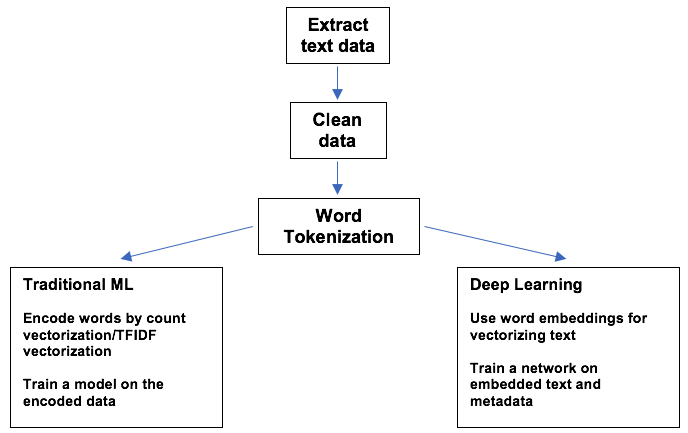

## Without Augmentation

### TF-IDF

In [ ]:
X_train.values[:10]

array(['type frame', 'wheels ka details', 'gas tank',
       'augmented filter kiase use krni hai',
       'kya mei iss bike ko app se book kr skta hu', 'fuel capacity',
       'kind sales network', 'covid safety measures',
       'warranty claim ka procedure batao', 'windscreen available'],
      dtype=object)

In [ ]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train.values)

X_train_tfidf = tfidf_vect.transform(X_train.values)
X_test_tfidf = tfidf_vect.transform(X_test.values)

#### MultinomialNB

In [ ]:
NB_clf = MultinomialNB()
parameters = {'alpha': np.random.uniform(0.001,10,30)}

randomSearch = RandomizedSearchCV(NB_clf,parameters,cv=2, n_iter=10,n_jobs=-1)
randomSearch.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                           fit_prior=True),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': array([2.87863942, 4.75941622, 2.63777368, 4.22028197, 1.25532499,
       8.13238179, 8.28031904, 1.36248781, 4.03866157, 0.22366751,
       9.22838305, 9.41635162, 0.98419093, 5.59398505, 0.38937863,
       8.7697441 , 7.15057214, 3.04060751, 6.76778933, 6.07707145,
       5.01729755, 9.9141042 , 5.39553062, 0.50730846, 6.79624449,
       2.50412715, 4.39374381, 4.22285214, 3.87683637, 0.29751341])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
NB_clf = MultinomialNB(**randomSearch.best_params_)
NB_clf.fit(X_train_tfidf,y_train)

MultinomialNB(alpha=0.22366751429268134, class_prior=None, fit_prior=True)

==================== Model metrics ====================
   accuracy  F1_score  precision    recall       auc
0  0.745902  0.747945   0.745902  0.745902  0.951863


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                              newDesign
isko apne hisab se bana sakta hu                    newDesign
customize classic                                         miy
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                               newDesign
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bike mei       newDesign


==================== Confusion Matrix ====================


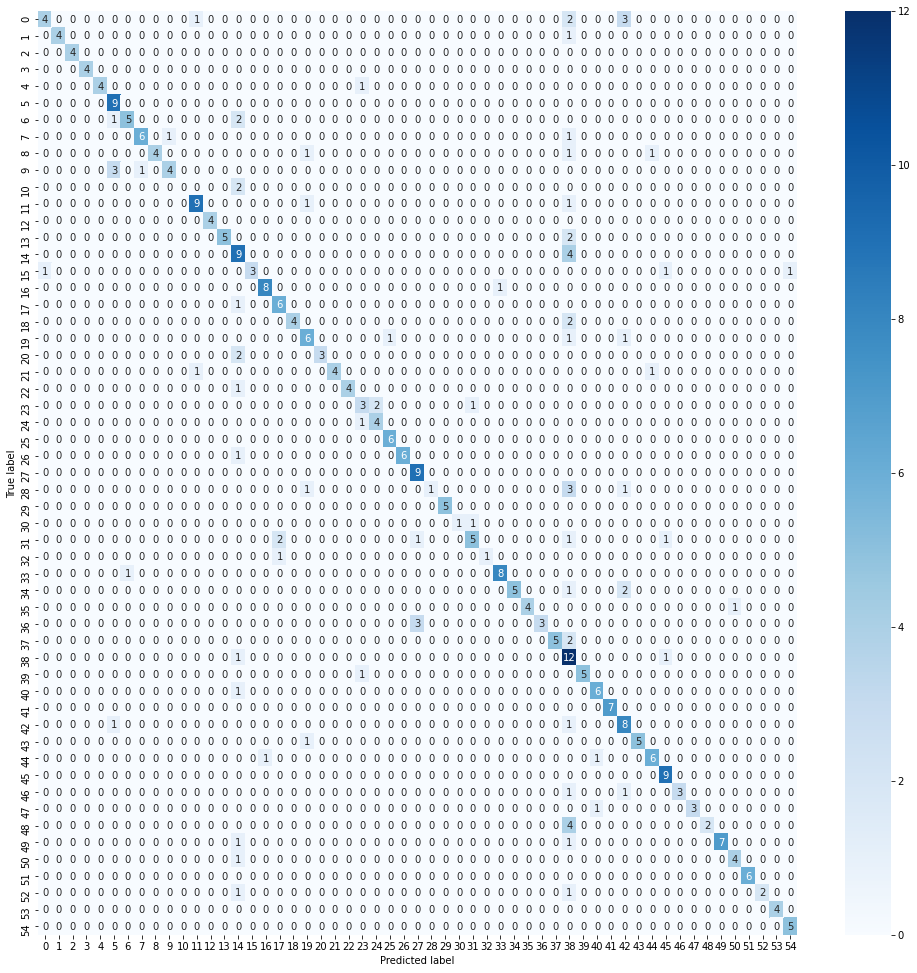

In [ ]:
NB_CLF_METRICS = metrics_plot(model = NB_clf,true = y_test,to_pred = X_test_tfidf,X_test = X_test)

In [ ]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

class_labels = NB_clf.classes_
feature_names =tfidf_vect.get_feature_names()

print("Important words for each class. \n")
for c in range(len(class_labels)):
  feature_importance_dictionary = sorted(zip(NB_clf.feature_log_prob_[c], feature_names),reverse=True)[:3]
  print("Class\t coefficient\t\t Important_word ")
  for coef, feat in feature_importance_dictionary:
      print(class_labels[c], coef,'\t', feat)
  print('='*30)

Important words for each class. 

Class	 coefficient		 Important_word 
Apparel -3.8127542009417654 	 helmet
Apparel -4.069766043165938 	 tshirts
Apparel -4.252956200803362 	 shirts
Class	 coefficient		 Important_word 
Headlamps -4.584523461062724 	 headlamps
Headlamps -4.637229934596146 	 led
Headlamps -4.637229934596146 	 headlight
Class	 coefficient		 Important_word 
abs -3.4310612316423326 	 abs
abs -4.943314642456892 	 switchable
abs -4.991748818205607 	 tyres
Class	 coefficient		 Important_word 
airCooled -3.5838512860025773 	 cooled
airCooled -4.144557097626759 	 oil
airCooled -4.444601232420491 	 air
Class	 coefficient		 Important_word 
battery -3.4611655418571905 	 battery
battery -4.410449020644732 	 much
battery -4.522373484356693 	 life
Class	 coefficient		 Important_word 
bookTestRide -3.0781649192065528 	 test
bookTestRide -3.100615355872074 	 ride
bookTestRide -4.630773821443779 	 want
Class	 coefficient		 Important_word 
bookingAmount -4.014531087857394 	 test
bookingAmo

In [ ]:
def predict_check(text,clf,vect):
    clean = preprocess(text)
    vec = vect.transform([clean])
    result = clf.predict(vec)
    return result[0]

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,NB_clf,tfidf_vect))

engineDisplacement
fuelCapacity
fuelCapacity


#### RandomForest Classifer

In [ ]:
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

rf_model = RandomForestClassifier()
rfCV_model = RandomizedSearchCV(rf_model, model_params, n_iter=100, cv=2, random_state=1)
rfCV_model = rfCV_model.fit(X_train_tfidf, y_train)

print(rfCV_model.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.3303165859427697, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 0.05772970407036965, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 38, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
n_estimators = rfCV_model.best_estimator_.get_params()['n_estimators']
max_features = rfCV_model.best_estimator_.get_params()['max_features']
min_samples_split = rfCV_model.best_estimator_.get_params()['min_samples_split']

In [ ]:
RF_clf = RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split)
RF_clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None,
                       max_features=0.3303165859427697, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=0.05772970407036965,
                       min_weight_fraction_leaf=0.0, n_estimators=38,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

==================== Model metrics ====================
   accuracy  F1_score  precision    recall      auc
0  0.672131  0.677686   0.672131  0.672131  0.94826


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                           ducatiLegacy
isko apne hisab se bana sakta hu                bookingAmount
customize classic                                     Apparel
much will maintainence cost                           mileage
bad service                                        complaints
triumph variant ducati                                 ducati
shoes                                                 Apparel
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bike mei           power


==================== Confusion Matrix ====================


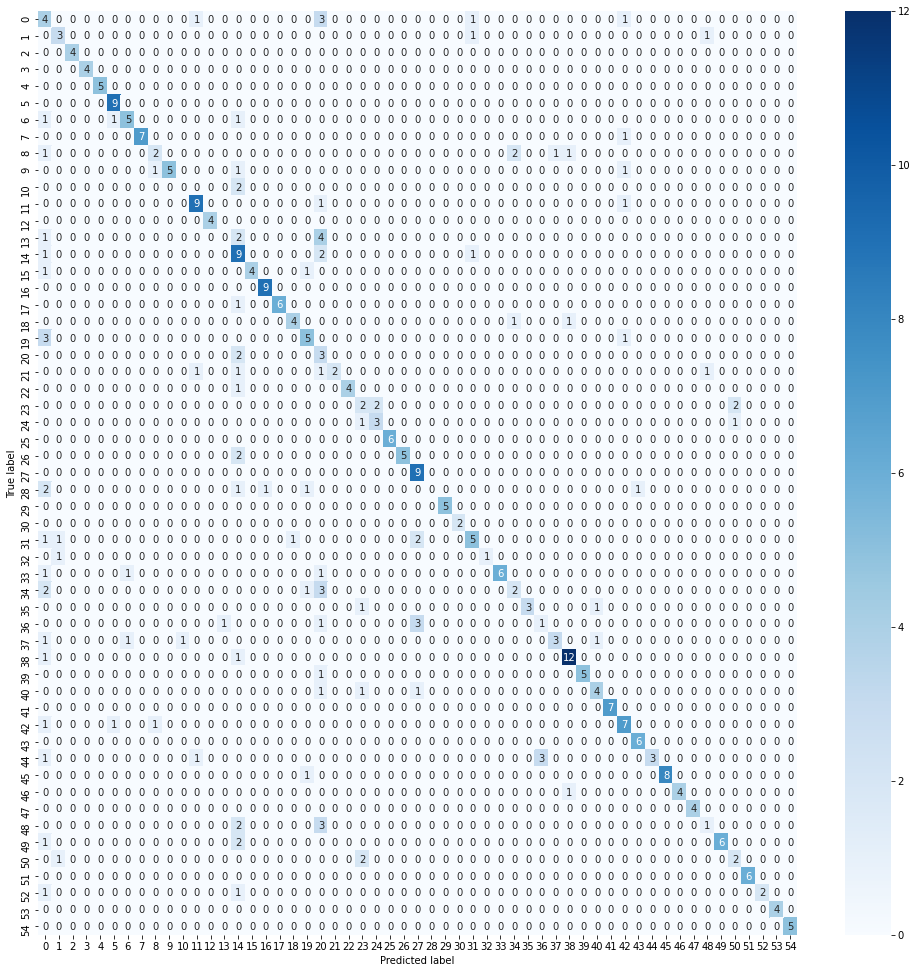

In [ ]:
RF_CLF_METRICS = metrics_plot(model = RF_clf,true = y_test,to_pred = X_test_tfidf,X_test = X_test)

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,RF_clf,tfidf_vect))

engine
fuelCapacity
fuelCapacity


#### Logistic Regression

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
LR_clf = LogisticRegression()
params  = {'C' : np.logspace(0, 4, 20)}

randomSearch = RandomizedSearchCV(LR_clf,params,cv=2,n_iter=100,n_jobs=-1)
randomSearch.fit(X_train_tfidf,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': a...0e+00,
       6.95192796e+00, 1.12883789e+01, 1.83298071e+01, 2.97635144e+01,
       4.83293024e+01, 7.84759970e+01, 1.27427499e+02, 2.06913808e+02,
       3.35981829e+02, 5.45559478e+02, 8.85866790e+02, 1.43844989e+03,
       2.3357

In [ ]:
LR_clf = LogisticRegression(**randomSearch.best_params_)
LR_clf.fit(X_train_tfidf,y_train)

LogisticRegression(C=127.42749857031335, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
LR_clf = LogisticRegression()
LR_clf.fit(X_train_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

==================== Model metrics ====================
   accuracy  F1_score  precision    recall      auc
0  0.710383  0.720222   0.710383  0.710383  0.95287


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                                 ducati
isko apne hisab se bana sakta hu                    newDesign
customize classic                                         miy
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                               newDesign
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bike mei       newDesign


==================== Confusion Matrix ====================


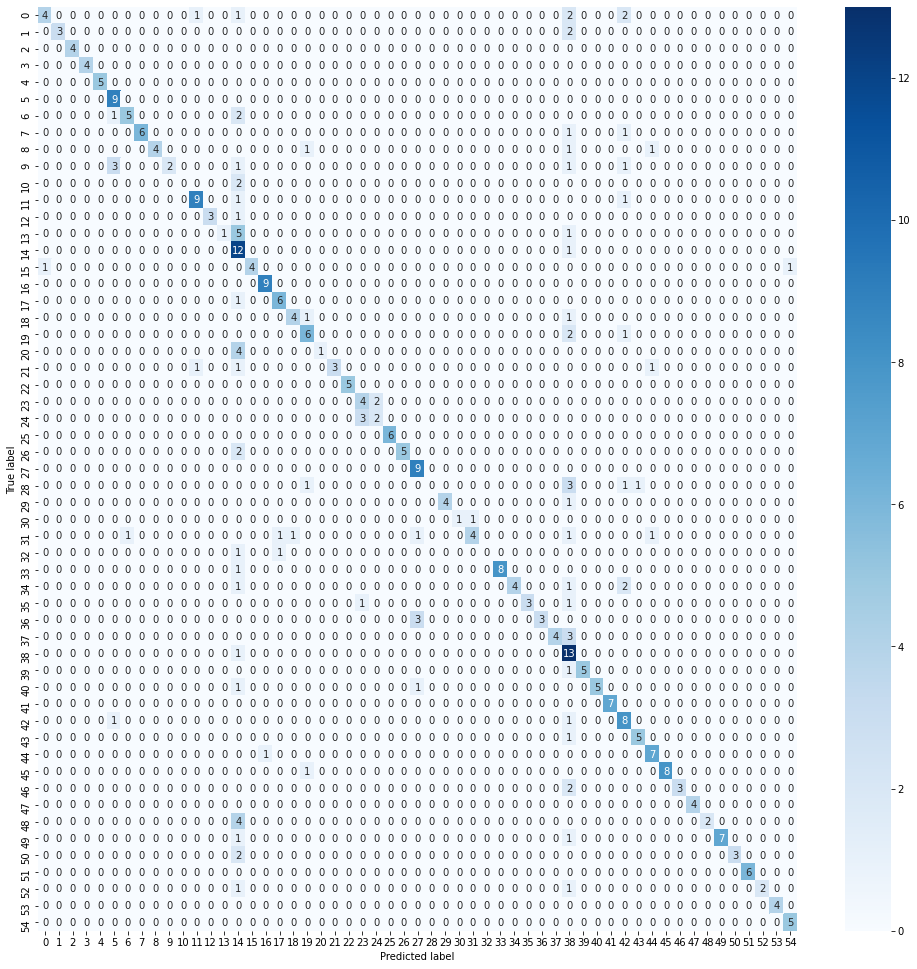

In [ ]:
LR_CLF_METRICS = metrics_plot(model = LR_clf,true = y_test,to_pred = X_test_tfidf,X_test = X_test)

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,LR_clf,tfidf_vect))

engineDisplacement
fuelCapacity
fuelCapacity


#### SVM

In [ ]:
SV_clf = SVC()
parameters = {'C': np.random.uniform(0.001,10,30),
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

randomSearch = RandomizedSearchCV(SV_clf,parameters,cv=5, n_iter=10,n_jobs=-1)
randomSearch.fit(X_train_tfidf,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': array([4.43315...
       8.08918435, 3.04880886, 1.84705738, 6.71289481, 1.84566969,
       4.88213297, 9.2925083 , 4.76144846, 4.2166395 , 2.26521237,
       3.57937482, 9.33078021, 0.52119466, 0.95324935, 1.13294292,
       9.7032526 , 5.08307524, 0.22108247, 2.00368148, 1.70429291]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmo

In [ ]:
SV_clf = SVC(**randomSearch.best_params_,probability=True)
SV_clf.fit(X_train_tfidf,y_train)

SVC(C=4.565814770430258, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

==================== Model metrics ====================
   accuracy  F1_score  precision   recall       auc
0   0.76776  0.769863    0.76776  0.76776  0.939675


==================== Example output ====================
                                                                Predicted
ducati good motorcycle                                      bookingAmount
isko apne hisab se bana sakta hu                                   ducati
customize classic                                                     miy
much will maintainence cost                    ducatiAvailabilityDelivery
bad service                                                    complaints
triumph variant ducati                                            triumph
shoes                                                           newDesign
placed navigation                                           tbtNavigation
new features ducati                                        ducatiFeatures
customization ke kya options hai iss bike

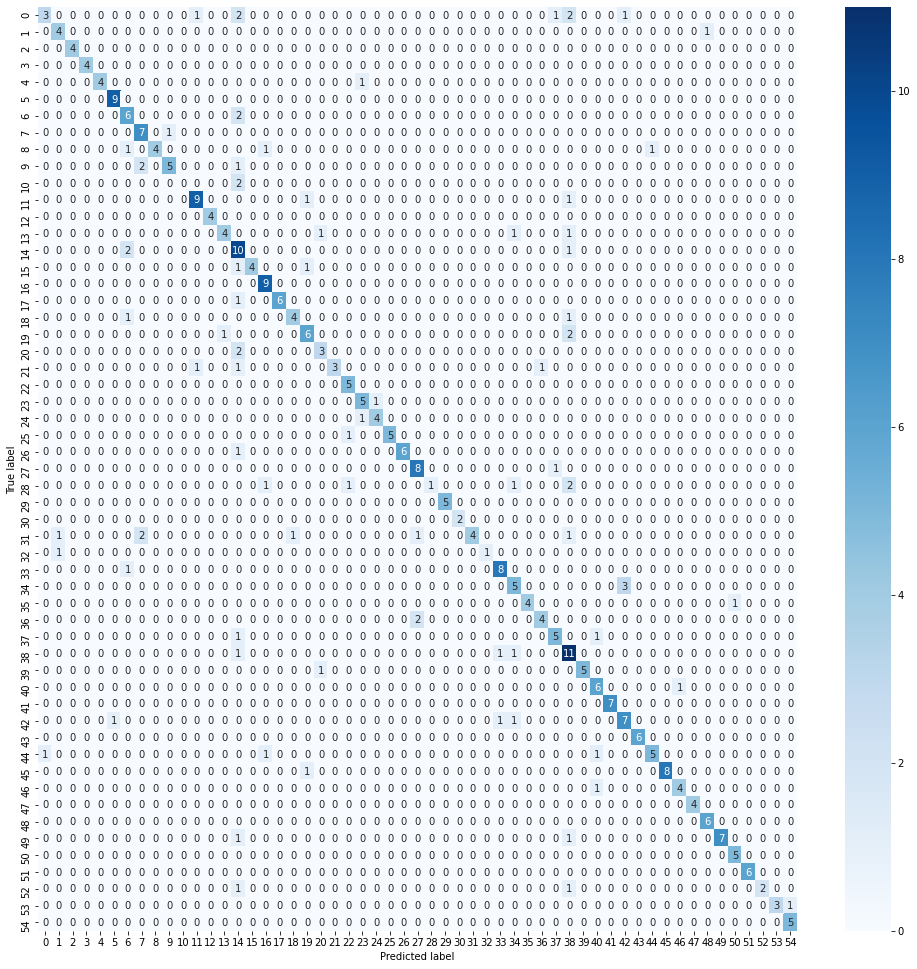

In [ ]:
SV_CLF_METRICS = metrics_plot(model = SV_clf,true = y_test,to_pred = X_test_tfidf,X_test = X_test)

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,SV_clf,tfidf_vect))

engineDisplacement
fuelCapacity
fuelCapacity


In [ ]:
ML_Comparison = pd.DataFrame([SV_CLF_METRICS,LR_CLF_METRICS,RF_CLF_METRICS,NB_CLF_METRICS],
                             index = ['Support Vector Classifier',
                                      'Logistic Regression',
                                      'Random Forest',
                                      'Naive Bayes'])
ML_Comparison

,accuracy,F1_score,precision,recall,auc
Support Vector Classifier,0.767760,0.769863,0.767760,0.767760,0.939675
Logistic Regression,0.710383,0.720222,0.710383,0.710383,0.952870
Random Forest,0.672131,0.677686,0.672131,0.672131,0.948260
Naive Bayes,0.745902,0.747945,0.745902,0.745902,0.951863


## With Augmentation

In [ ]:
X_train_augmented = new_train_data['message']
y_train_augmented = new_train_data['intent']

### TF-IDF

In [ ]:
X_train.values[:10]

array(['type frame', 'wheels ka details', 'gas tank',
       'augmented filter kiase use krni hai',
       'kya mei iss bike ko app se book kr skta hu', 'fuel capacity',
       'kind sales network', 'covid safety measures',
       'warranty claim ka procedure batao', 'windscreen available'],
      dtype=object)

In [ ]:
tfidf_vect_aug = TfidfVectorizer()
tfidf_vect_aug.fit(X_train_augmented.values)

X_train_tfidf_aug = tfidf_vect_aug.transform(X_train_augmented.values)
X_test_tfidf_aug = tfidf_vect_aug.transform(X_test.values)

#### MultinomialNB

In [ ]:
NB_clf = MultinomialNB()
parameters = {'alpha': np.random.uniform(0.001,10,30)}

randomSearch = RandomizedSearchCV(NB_clf,parameters,cv=5, n_iter=10)
randomSearch.fit(X_train_tfidf_aug,y_train_augmented)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                           fit_prior=True),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': array([8.99282   , 8.47401261, 6.30382652, 8.51734065, 2.93294614,
       2.93892509, 1.70492578, 0.55735576, 6.29451754, 5.99965073,
       3.75684724, 8.35801015, 5.45870134, 2.91890874, 7.23054426,
       0.33313191, 0.67760342, 6.91931885, 8.99242037, 2.09427794,
       1.0774367 , 1.86010239, 3.79934807, 0.88758363, 7.74804608,
       1.17259821, 7.14028858, 6.58397589, 0.26866823, 6.34799018])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
NB_clf_aug = MultinomialNB(**randomSearch.best_params_)
NB_clf_aug.fit(X_train_tfidf_aug,y_train_augmented)

MultinomialNB(alpha=1.1725982063183706, class_prior=None, fit_prior=True)

==================== Model metrics ====================
   accuracy  F1_score  precision    recall       auc
0  0.737705  0.740475   0.787036  0.758456  0.946693


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                                triumph
isko apne hisab se bana sakta hu                    ducatiApp
customize classic                                     upgrade
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                               newDesign
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bike mei       ducatiApp


==================== Confusion Matrix ====================


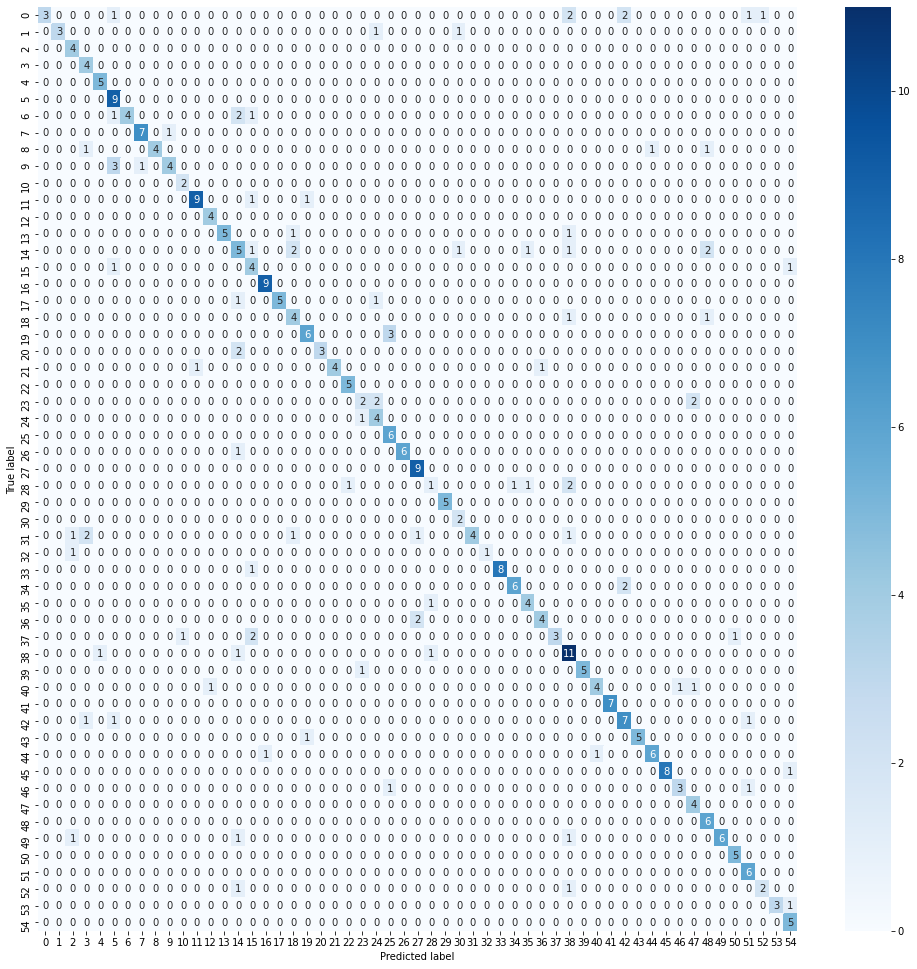

In [ ]:
NB_CLF_METRICS_AUG = metrics_plot(model = NB_clf_aug,true = y_test,to_pred = X_test_tfidf_aug,X_test = X_test,augmentation=True)

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,NB_clf_aug,tfidf_vect_aug))

engineDisplacement
fuelCapacity
fuelCapacity


In [ ]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

class_labels = NB_clf_aug.classes_
feature_names =tfidf_vect_aug.get_feature_names()

print("Important words for each class. \n")
for c in range(len(class_labels)):
  feature_importance_dictionary = sorted(zip(NB_clf_aug.feature_log_prob_[c], feature_names),reverse=True)[:3]
  print("Class\t coefficient\t\t Important_word ")
  for coef, feat in feature_importance_dictionary:
      print(class_labels[c], coef,'\t', feat)
  print('='*30)

Important words for each class. 

Class	 coefficient		 Important_word 
Apparel -4.87916241607037 	 helmet
Apparel -5.031558488694801 	 tshirts
Apparel -5.141846464658612 	 shirts
Class	 coefficient		 Important_word 
Headlamps -4.945990268072302 	 headlamps
Headlamps -4.969545725927543 	 led
Headlamps -5.012888417672007 	 headlight
Class	 coefficient		 Important_word 
abs -4.356753417250847 	 abs
abs -4.852969071183237 	 tyres
abs -4.856420942681006 	 switchable
Class	 coefficient		 Important_word 
airCooled -4.341216332736845 	 cooled
airCooled -4.529526435858903 	 air
airCooled -4.730058287858777 	 oil
Class	 coefficient		 Important_word 
battery -4.494518355455025 	 battery
battery -4.8745198468687105 	 konsi
battery -4.885396782346666 	 si
Class	 coefficient		 Important_word 
bookTestRide -4.262004389480568 	 test
bookTestRide -4.311584108302172 	 ride
bookTestRide -5.067203566438782 	 karni
Class	 coefficient		 Important_word 
bookingAmount -4.953647442424395 	 booking
bookingAmoun

#### RandomForest Classifer

In [ ]:
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

rf_model_aug = RandomForestClassifier()
rfCV_model_aug = RandomizedSearchCV(rf_model_aug, model_params, n_iter=100, cv=5, random_state=1,n_jobs=-1)
rfCV_model_aug = rfCV_model_aug.fit(X_train_tfidf_aug, y_train_augmented)

print(rfCV_model_aug.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.31965224652748636, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 0.023240759789468872, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 182, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
n_estimators = rfCV_model_aug.best_estimator_.get_params()['n_estimators']
max_features = rfCV_model_aug.best_estimator_.get_params()['max_features']
min_samples_split = rfCV_model_aug.best_estimator_.get_params()['min_samples_split']

In [ ]:
RF_clf_aug = RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split)
RF_clf_aug.fit(X_train_tfidf_aug, y_train_augmented)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None,
                       max_features=0.31965224652748636, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=0.023240759789468872,
                       min_weight_fraction_leaf=0.0, n_estimators=182,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


==================== Model metrics ====================
   accuracy  F1_score  precision   recall       auc
0  0.710383  0.728687    0.78876  0.72498  0.955894


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                           ducatiLegacy
isko apne hisab se bana sakta hu                       ducati
customize classic                                     upgrade
much will maintainence cost                           mileage
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                                 Apparel
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bike mei           power


==================== Confusion Matrix ====================


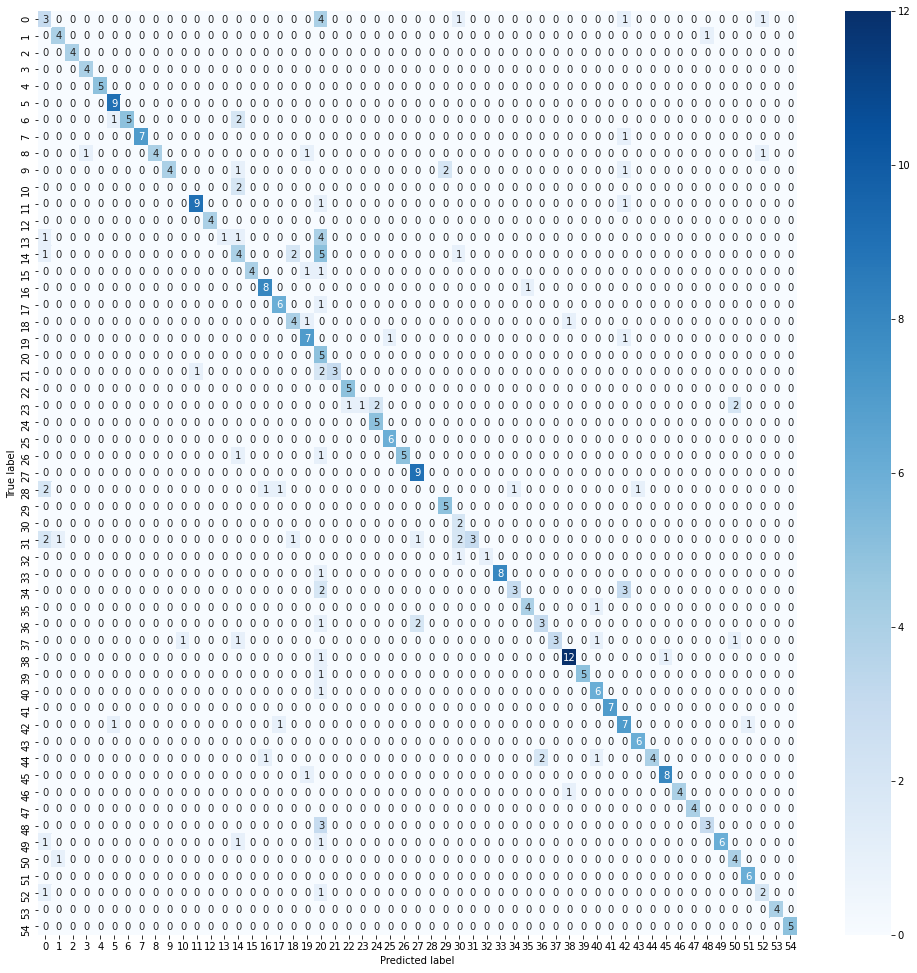

In [ ]:
RF_CLF_METRICS_AUG = metrics_plot(model = RF_clf_aug,true = y_test,to_pred = X_test_tfidf_aug,X_test = X_test,augmentation=True)

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,RF_clf_aug,tfidf_vect_aug))

engineDisplacement
fuelCapacity
engineDisplacement


#### Logistic Regression

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
LR_clf_aug = LogisticRegression()
params  = {'C' : np.logspace(0, 4, 20)}

randomSearch_aug_lr = RandomizedSearchCV(LR_clf_aug,params,cv=5,n_iter=100,n_jobs=-1)
randomSearch_aug_lr.fit(X_train_tfidf_aug,y_train_augmented)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': a...0e+00,
       6.95192796e+00, 1.12883789e+01, 1.83298071e+01, 2.97635144e+01,
       4.83293024e+01, 7.84759970e+01, 1.27427499e+02, 2.06913808e+02,
       3.35981829e+02, 5.45559478e+02, 8.85866790e+02, 1.43844989e+03,
       2.3357

In [ ]:
LR_clf_aug = LogisticRegression(**randomSearch_aug_lr.best_params_)
LR_clf_aug.fit(X_train_tfidf_aug,y_train_augmented)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


==================== Model metrics ====================
   accuracy  F1_score  precision    recall       auc
0  0.765027  0.767753   0.789339  0.765954  0.953647


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                                 ducati
isko apne hisab se bana sakta hu                tbtNavigation
customize classic                                     upgrade
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                               newDesign
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bike mei       ducatiApp


==================== Confusion Matrix ====================


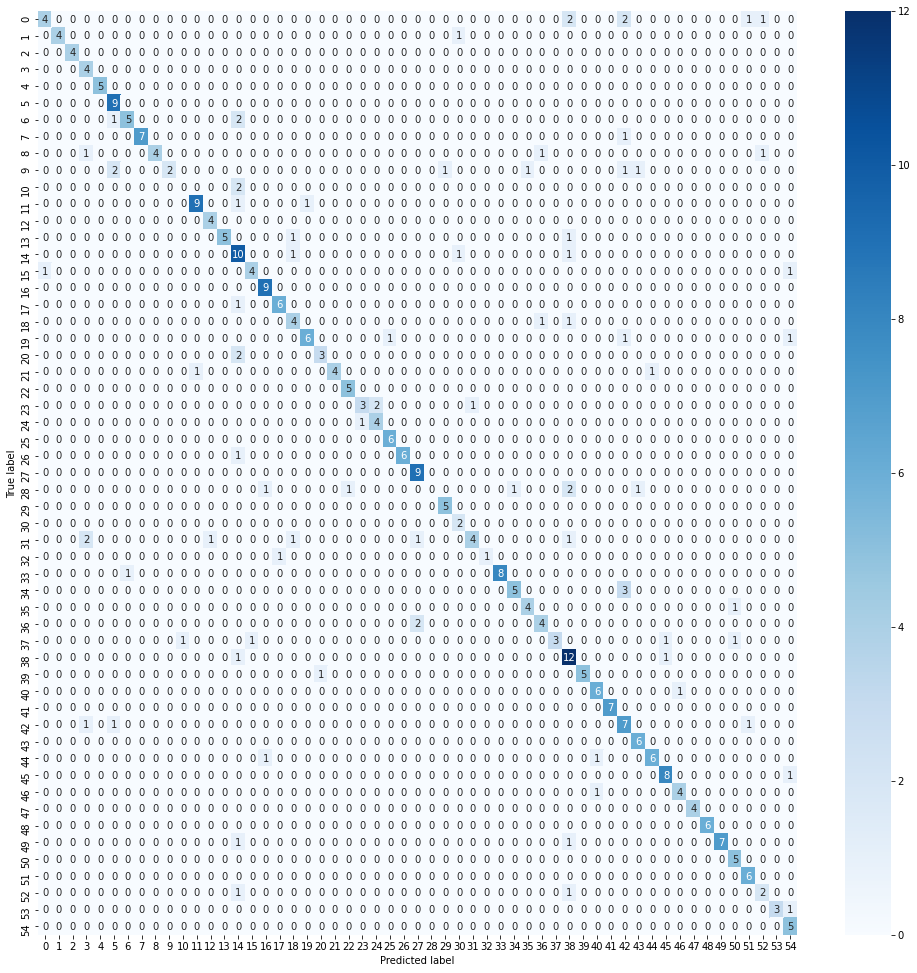

In [ ]:
LR_CLF_METRICS_AUG = metrics_plot(model = LR_clf_aug,true = y_test,to_pred = X_test_tfidf_aug,X_test = X_test,augmentation=True)

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,LR_clf_aug,tfidf_vect_aug))

engineDisplacement
fuelCapacity
fuelCapacity


#### SVM

In [ ]:
SV_clf_aug = SVC()
parameters = {'C': np.random.uniform(0.001,10,30),
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

randomSearch_aug_svc = RandomizedSearchCV(SV_clf_aug,parameters,cv=5, n_iter=10)
randomSearch_aug_svc.fit(X_train_tfidf_aug,y_train_augmented)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([2.987...
       3.55726393, 4.47163888, 6.61536826, 6.77748637, 5.54090119,
       6.43061602, 7.01097349, 7.82025748, 5.31581345, 3.01334821,
       2.01977823, 9.71774977, 1.7623179 , 5.87912412, 8.05911093,
       0.51962744, 7.54351215, 2.11258455, 6.92341572, 5.75461945]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmo

In [ ]:
SV_clf_aug = SVC(**randomSearch_aug_svc.best_params_,probability=True)
SV_clf_aug.fit(X_train_tfidf_aug,y_train_augmented)

SVC(C=1.7623178985613257, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


==================== Model metrics ====================
   accuracy  F1_score  precision    recall       auc
0  0.781421  0.796011   0.834144  0.777085  0.953302


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                                 ducati
isko apne hisab se bana sakta hu                    newDesign
customize classic                                         miy
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                               newDesign
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bike mei   ducatiColours


==================== Confusion Matrix ====================


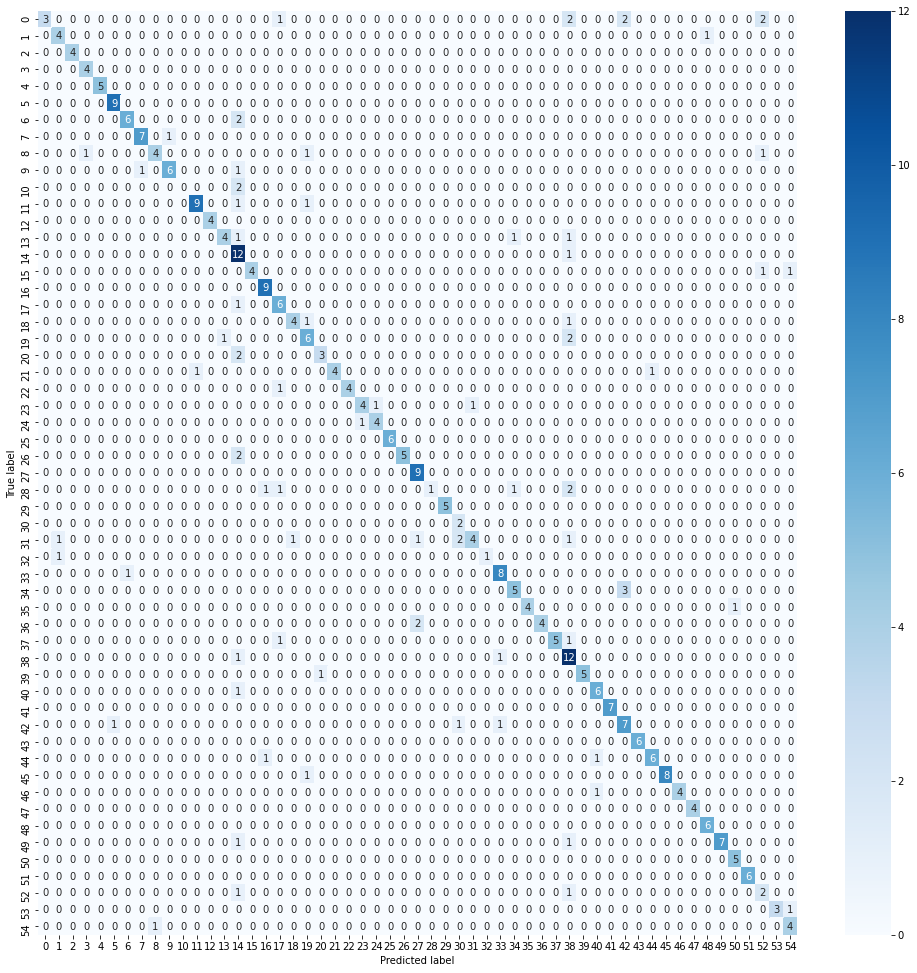

In [ ]:
SV_CLF_METRICS_AUG = metrics_plot(model = SV_clf_aug,true = y_test,to_pred = X_test_tfidf,X_test = X_test,augmentation=True)

In [ ]:
ML_Comparison_aug = pd.DataFrame([SV_CLF_METRICS_AUG,LR_CLF_METRICS_AUG,RF_CLF_METRICS_AUG,NB_CLF_METRICS_AUG],
                             index = ['Support Vector Classifier (AUG)',
                                      'Logistic Regression (AUG)',
                                      'Random Forest (AUG)',
                                      'Naive Bayes (AUG)'])

In [ ]:
te = ['how much is engine displacement','What is the fuel tank capacity?','I want to know about engine displacement and fuel capacity']
for t in te:
  print(predict_check(t,SV_clf_aug,tfidf_vect_aug))

engineDisplacement
fuelCapacity
fuelCapacity


## ML Model Comparison

In [ ]:
ML_Comparison_aug

,accuracy,F1_score,precision,recall,auc
Support Vector Classifier (AUG),0.781421,0.796011,0.834144,0.777085,0.953302
Logistic Regression (AUG),0.765027,0.767753,0.789339,0.765954,0.953647
Random Forest (AUG),0.710383,0.728687,0.788760,0.724980,0.955894
Naive Bayes (AUG),0.737705,0.740475,0.787036,0.758456,0.946693


In [ ]:
ML_Comparison

,accuracy,F1_score,precision,recall,auc
Support Vector Classifier,0.767760,0.769863,0.767760,0.767760,0.939675
Logistic Regression,0.710383,0.720222,0.710383,0.710383,0.952870
Random Forest,0.672131,0.677686,0.672131,0.672131,0.948260
Naive Bayes,0.745902,0.747945,0.745902,0.745902,0.951863


Thus we observe, that after balancing the data with augmentation, we are getting not much difference in the precision and recall, considering Logistic regresssion or SVC outperforming other mdoels , although with small performance difference.


---
when you have a data imbalance between positive and negative samples, you should always use F1-score because ROC averages over all possible thresholds


# Deep learning Models

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense,Input,Embedding,LSTM,Dropout,Flatten,Conv1D,concatenate,MaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras import Model

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(

#### Neural Network Performance metric Plot preperation

In [ ]:
def NN_metrics_plot(model,to_pred,true,unencoded_true_X,unencoded_true_y):
    """
    Function to plot neural network metrics
    INPUT - 
          model : the selected trainded neural network model
          to_pred : test data after preprocessing
          true : encoded Ground truth values
          unencoded_true_X : test sentences
          unencoded_true_y : Ground truth values
    RETRUNS - 
          metric type(dict)
    """
    _, accuracy, f1_score, precision, recall = model.evaluate(to_pred, true)

    NN_metric={}
    NN_metric['accuracy'] = accuracy
    NN_metric['F1_score'] = f1_score
    NN_metric['precision'] = precision
    NN_metric['recall'] = recall

    print("="*20,"Model metrics","="*20)
    print(pd.DataFrame([NN_metric]))

    try:
        outputs=[]
        for i in range(10):
            pred = model.predict(to_pred[i].reshape(1,-1))
            output = encoder.inverse_transform([np.argmax(pred[0])])[0]
            outputs.append(output)
        sent_to_classify = list(unencoded_true_X)[:10]
        print("\n")
        print("="*20,"Example output","="*20)
        print(pd.DataFrame(outputs,sent_to_classify,columns=['Predicted']))

        print("\n")
        print("="*20,"Confusion Matrix","="*20)
        predicted=[]
        for i in range(true.shape[0]):
            pred = model.predict(to_pred[i].reshape(1,-1))
            output = encoder.inverse_transform([np.argmax(pred[0])])[0]
            predicted.append(output)
            
        plt.figure(figsize=(17,17))
        sns.heatmap(confusion_matrix(unencoded_true_y,predicted),annot=True,cmap='Blues')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
    except:
      pass
    return NN_metric

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Simple Artificial Neural Network

* Bag of words with keras




### Preprocessing

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [ ]:
num_classes = np.max(y_train_encoded) + 1
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

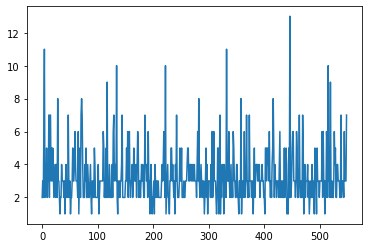

In [ ]:
length_of_sent = []
for sent in np.array(X_train):
    length_of_sent.append(len(sent.split()))
plt.plot(length_of_sent)

In [ ]:
max_len = np.mean(length_of_sent)
max_len = int(max_len)+3

In [ ]:
tknzr = Tokenizer()
tknzr.fit_on_texts(X_train)

In [ ]:
train_matrix = tknzr.texts_to_matrix(X_train)
test_matrix = tknzr.texts_to_matrix(X_test)

### Model preperation and training

In [ ]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(train_matrix[0].shape))
layer = Dense(512,activation='relu')(input_layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(64,activation='relu')(layer)
output_layer = Dense(55,activation='softmax')(layer)

ANNmodel = Model(inputs=input_layer,outputs=output_layer)

ANNmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
ANNmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 585)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               300032    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 55)                3575      
Total params: 377,527
Trainable params: 377,527
Non-trainable params: 0
_______________________________________________________

In [ ]:
ANNmodel.fit(train_matrix,y_train_encoded,validation_split=0.1,batch_size=8,verbose=1,epochs=60)

Epoch 1/60
62/62 [==============================] - 15s 13ms/step - loss: 4.0032 - accuracy: 0.0199 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.9328 - val_accuracy: 0.0545 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/60
62/62 [==============================] - 0s 4ms/step - loss: 3.8422 - accuracy: 0.0999 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.7409 - val_accuracy: 0.0727 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/60
62/62 [==============================] - 0s 3ms/step - loss: 3.4455 - accuracy: 0.1927 - f1_m: 0.0042 - precision_m: 0.0189 - recall_m: 0.0024 - val_loss: 3.3354 - val_accuracy: 0.1636 - val_f1_m: 0.0675 - val_precision_m: 0.2857 - val_recall_m: 0.0383
Epoch 4/60
62/62 [==============================] - 0s 4ms/step - loss: 2.5533 - accuracy: 0.3908 - f1_m: 0.0789 - precision_m: 0.2699 - recall_m: 0.0473 - va

### Metric plotting

12/12 [==============================] - 0s 3ms/step - loss: 2.4883 - accuracy: 0.7104 - f1_m: 0.7464 - precision_m: 0.7892 - recall_m: 0.7087
==================== Model metrics ====================
   accuracy  F1_score  precision    recall
0  0.710383  0.746353   0.789178  0.708705


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                         ducatiVariants
isko apne hisab se bana sakta hu                    newDesign
customize classic                                         miy
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                              newDesign
shoes                                                     miy
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss

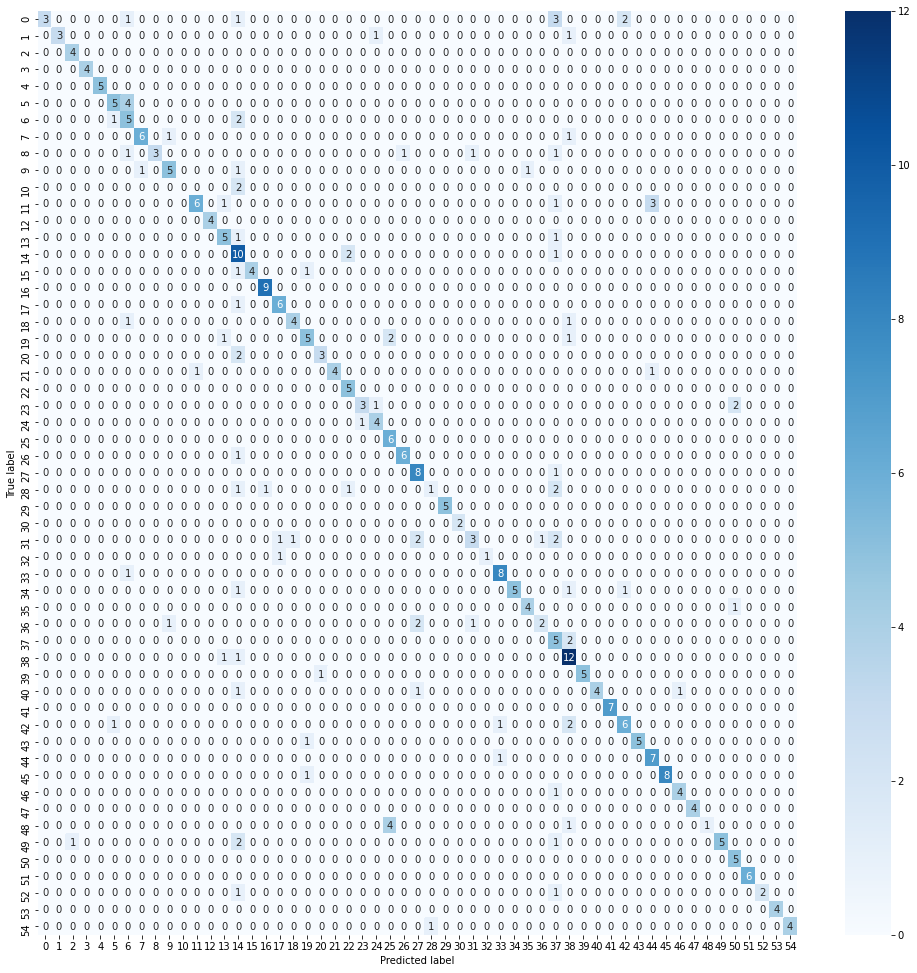

In [ ]:
ANN_MODEL_METRIC = NN_metrics_plot(model = ANNmodel,to_pred=test_matrix,true=y_test_encoded,unencoded_true_X=X_test,unencoded_true_y = y_test)

## Classification with LSTM

### Preprocessing

In [ ]:
vocabulary = tknzr.word_index

In [ ]:
print(f' The word token dictionary : \n {dict(list(tknzr.word_index.items())[0: 10])}')

 The word token dictionary : 
 {'ducati': 1, 'hai': 2, 'engine': 3, 'kya': 4, 'bike': 5, 'ride': 6, 'will': 7, 'motorcycle': 8, 'test': 9, 'ye': 10}


In [ ]:
train_seq = tknzr.texts_to_sequences(X_train)
test_seq = tknzr.texts_to_sequences(X_test)

In [ ]:
train_padded = pad_sequences(train_seq,maxlen = max_len,padding='post')
test_padded = pad_sequences(test_seq,maxlen=max_len,padding='post')

In [ ]:
print(f'Train data shape after padding: {train_padded.shape}')
print(f'Test data shape after padding: {test_padded.shape}')
print(f'Examples of paadding : \n {train_padded[34]},\n {train_padded[24]}, \n {train_padded[15]}')

Train data shape after padding: (549, 6)
Test data shape after padding: (366, 6)
Examples of paadding : 
 [ 87 296   0   0   0   0],
 [ 63 176   0   0   0   0], 
 [132 133  11 175 108  62]


In [ ]:
train_padded.shape

(549, 6)

### W2V

Training on custom dataset


In [ ]:
# list_of_sent = []
# lines = list(X_train)

# for line in lines:
#     tokens = word_tokenize(line)
#     tokens = [w.lower() for w in tokens]
#     table = str.maketrans('', '', string.punctuation)
#     stripped = [w.translate(table) for w in tokens]
#     words = [word for word in stripped if word.isalpha()]
#     list_of_sent.append(words)
    
# list_of_sent[0:5]

In [ ]:
# w2v = gensim.models.Word2Vec(sentences=list_of_sent, size=100, window=5, workers=4, min_count=1, sg=0)
# vocab_words = list(w2v.wv.vocab)                                                                      
# print(len(vocab_words))

In [ ]:
# filename = "w2v_vectors.txt"
# w2v.wv.save_word2vec_format(filename, binary=False)

In [ ]:
# embedding_index = {}
# f = open(os.path.join('', 'w2v_vectors.txt'),  encoding = "utf-8")
# for line in f:
#     values = line.split()
#     word = values[0]
#     coeff = np.asarray(values[1:], dtype='float32')
#     embedding_index[word] = coeff
# f.close()

In [ ]:
# embedding_dim = 512
# embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))
# for word, i in vocabulary.items():
#     embedding_vector = embedding_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

### Model preperation and training

In [ ]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(train_padded.shape[1],),name='INPUT')
layer = Embedding(input_dim=len(vocabulary)+1,output_dim=512,name='EMBEDDING')(input_layer)
layer = LSTM(units=100,activation='relu',dropout=0.2, recurrent_dropout=0.2,name='LSTM')(layer)
layer = Dense(128,activation='relu',name='DENSE1')(layer)
output_layer =  Dense(55,activation='softmax',name='OUTPUT')(layer)

LSTMmodel = Model(inputs=input_layer,outputs = output_layer)

LSTMmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])


In [ ]:
LSTMmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 6, 512)            299520    
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               245200    
_________________________________________________________________
DENSE1 (Dense)               (None, 128)               12928     
_________________________________________________________________
OUTPUT (Dense)               (None, 55)                7095      
Total params: 564,743
Trainable params: 564,743
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTMmodel.fit(train_padded,y_train_encoded,validation_split=0.2,batch_size=16,verbose=1,epochs=30)

Epoch 1/30
28/28 [==============================] - 41s 70ms/step - loss: 4.0051 - accuracy: 0.0106 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.9965 - val_accuracy: 0.0091 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
28/28 [==============================] - 1s 34ms/step - loss: 3.9568 - accuracy: 0.0471 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.0208 - val_accuracy: 0.0182 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
28/28 [==============================] - 1s 32ms/step - loss: 3.8119 - accuracy: 0.0686 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.7988 - val_accuracy: 0.0818 - val_f1_m: 0.0317 - val_precision_m: 0.1429 - val_recall_m: 0.0179
Epoch 4/30
28/28 [==============================] - 1s 32ms/step - loss: 3.1090 - accuracy: 0.1942 - f1_m: 0.1186 - precision_m: 0.6430 - recall

### Metric plotting

12/12 [==============================] - 0s 6ms/step - loss: 3.0843 - accuracy: 0.6421 - f1_m: 0.6683 - precision_m: 0.7198 - recall_m: 0.6250
==================== Model metrics ====================
   accuracy  F1_score  precision  recall
0  0.642076  0.668262   0.719808   0.625


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                                 ducati
isko apne hisab se bana sakta hu                 bookTestRide
customize classic                                 faceFilters
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                                  ducati
placed navigation                               tbtNavigation
new features ducati                            ducatiFeatures
customization ke kya options hai iss bik

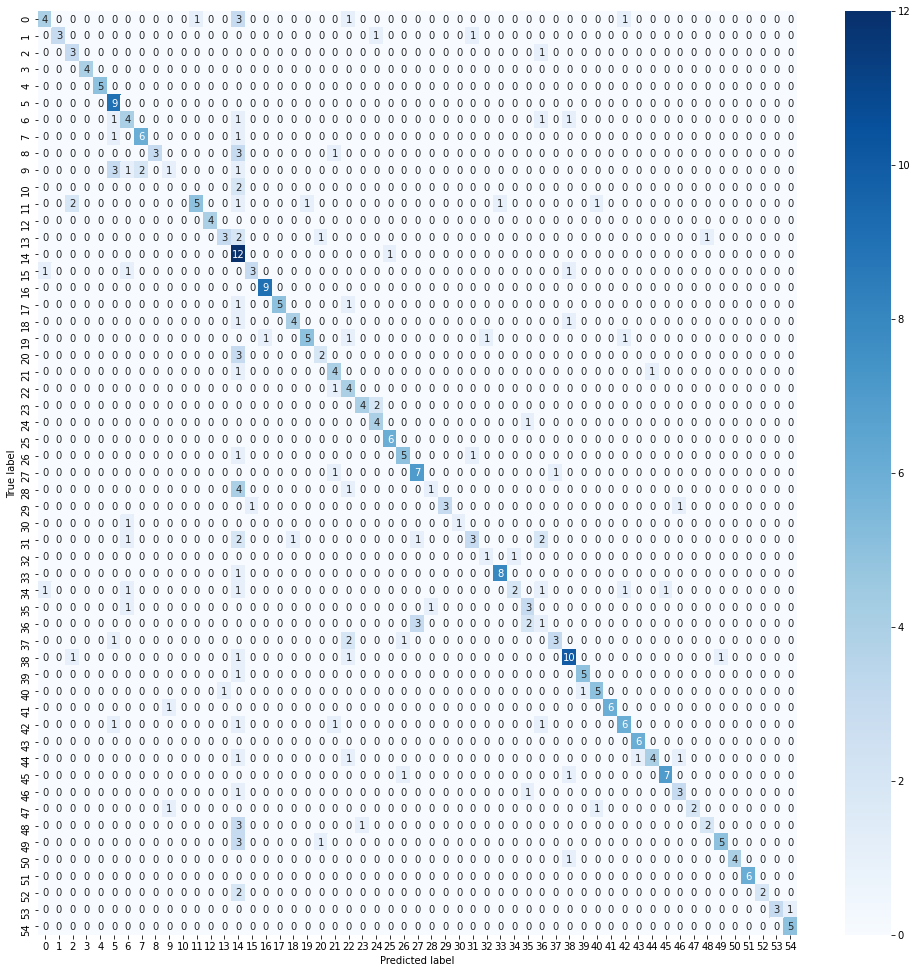

In [ ]:
LSTM_MODEL_METRIC = NN_metrics_plot(model = LSTMmodel,to_pred=test_padded,true=y_test_encoded,unencoded_true_X=X_test,unencoded_true_y = y_test)

## Classification using CNN

In [ ]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(train_padded.shape[1],),name='INPUT')
layer = Embedding(input_dim=len(vocabulary)+1,output_dim=512,name='EMBEDDING')(input_layer)
layer_cnn1 = Conv1D(filters=4,kernel_size=4,padding='same',activation='relu')(layer)
layer_cnn2 = Conv1D(filters=8,kernel_size=4,padding='same',activation='relu')(layer)
layer_cnn3 = Conv1D(filters=12,kernel_size=4,padding='same',activation='relu')(layer)

layer = concatenate([layer_cnn1,layer_cnn2,layer_cnn3])
layer = MaxPool1D(pool_size=10,padding="same")(layer)

layer = Flatten()(layer)
layer = Dropout(rate=0.01)(layer)
layer = Dense(64, activation='relu')(layer)
output_layer = Dense(55, activation='softmax')(layer)

CNNmodel = Model(inputs=input_layer,outputs = output_layer)

CNNmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])


In [ ]:
CNNmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 6)]          0                                            
__________________________________________________________________________________________________
EMBEDDING (Embedding)           (None, 6, 512)       299520      INPUT[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 6, 4)         8196        EMBEDDING[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 8)         16392       EMBEDDING[0][0]                  
______________________________________________________________________________________________

In [ ]:
CNNmodel.fit(train_padded,y_train_encoded,validation_split=0.2,batch_size=16,verbose=1,epochs=30)

Epoch 1/30
28/28 [==============================] - 32s 32ms/step - loss: 4.0065 - accuracy: 0.0246 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.9878 - val_accuracy: 0.0273 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
28/28 [==============================] - 0s 8ms/step - loss: 3.9140 - accuracy: 0.0957 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.9282 - val_accuracy: 0.0455 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
28/28 [==============================] - 0s 9ms/step - loss: 3.7196 - accuracy: 0.1657 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.7896 - val_accuracy: 0.1182 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 3.3219 - accuracy: 0.2723 - f1_m: 0.0014 - precision_m: 0.0064

12/12 [==============================] - 1s 4ms/step - loss: 2.0841 - accuracy: 0.6694 - f1_m: 0.6994 - precision_m: 0.8096 - recall_m: 0.6202
==================== Model metrics ====================
   accuracy  F1_score  precision    recall
0  0.669399  0.699402   0.809582  0.620164


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                                 ducati
isko apne hisab se bana sakta hu                bookingAmount
customize classic                                         miy
much will maintainence cost                       serviceCost
bad service                                        complaints
triumph variant ducati                                triumph
shoes                                                 mileage
placed navigation                              ducatiVariants
new features ducati                            ducatiFeatures
customization ke kya options hai iss

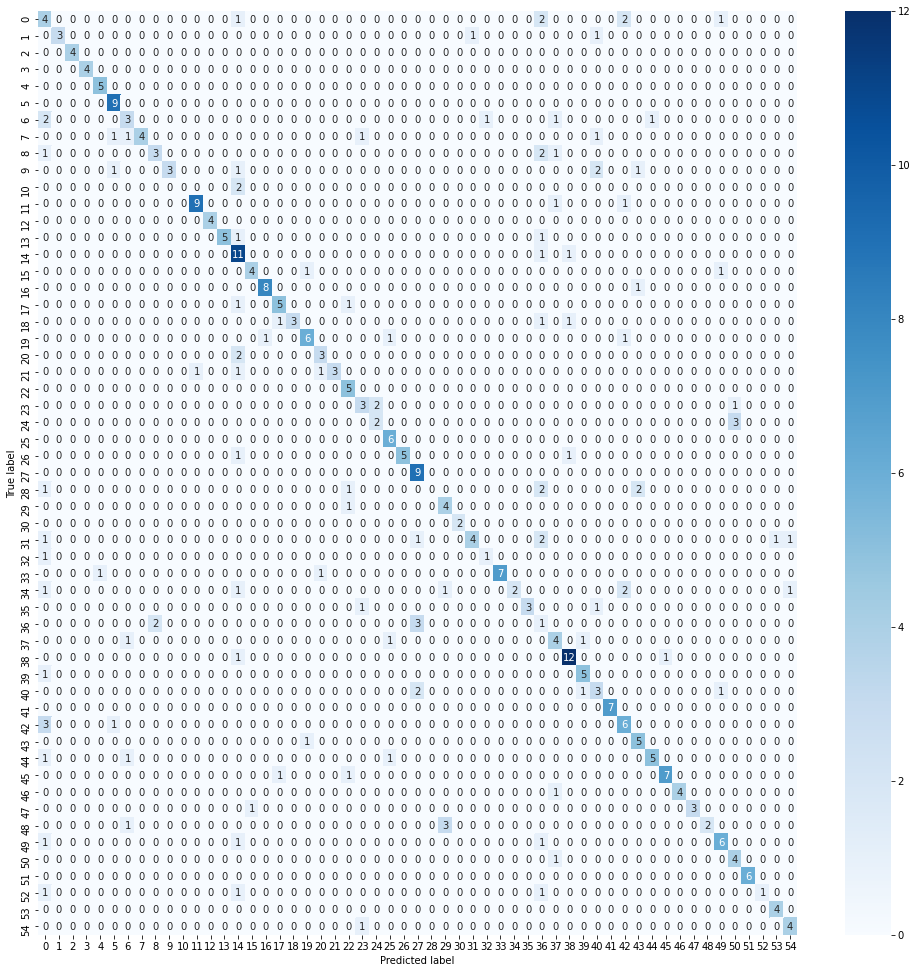

In [ ]:
CNN_MODEL_METRIC = NN_metrics_plot(model = CNNmodel,to_pred=test_padded,true=y_test_encoded,unencoded_true_X=X_test,unencoded_true_y = y_test)

## Classification with CNN at character level

### preprocessing

In [ ]:
tknzr_char = Tokenizer(char_level=True)
tknzr_char.fit_on_texts(X_train)

In [ ]:
vocabulary_char = tknzr_char.word_index

In [ ]:
print(f' The word token dictionary : \n {dict(list(tknzr_char.word_index.items())[0: 10])}')

 The word token dictionary : 
 {' ': 1, 'e': 2, 'a': 3, 'i': 4, 't': 5, 'r': 6, 's': 7, 'n': 8, 'o': 9, 'c': 10}


In [ ]:
train_seq_char = tknzr_char.texts_to_sequences(X_train)
test_seq_char = tknzr_char.texts_to_sequences(X_test)

In [ ]:
seq_len=[]
for i in range(len(train_seq_char)):
    seq_len.append(len(train_seq_char[i]))
print(max(seq_len))
print(np.median(seq_len))
print(np.mean(seq_len))

54
18.0
19.6775956284153


In [ ]:
max_len_char = 20

In [ ]:
train_padded_char = pad_sequences(train_seq_char,maxlen = max_len_char,padding='post')
test_padded_char = pad_sequences(test_seq_char,maxlen=max_len_char,padding='post')

In [ ]:
print(f'Train data shape after padding: {train_padded_char.shape}')
print(f'Test data shape after padding: {test_padded_char.shape}')
print(f'Examples of paadding : \n {train_padded_char[34]},\n {train_padded_char[24]}, \n {train_padded_char[15]}')

Train data shape after padding: (549, 20)
Test data shape after padding: (366, 20)
Examples of paadding : 
 [ 8  2  2 12  1  7 14  4  6  5  0  0  0  0  0  0  0  0  0  0],
 [11  4 17 14  5  7  1  4  8 12  4 10  3  5  9  6  7  0  0  0], 
 [ 8 13 16 18  2  6  1 10 14  3 14  4 19  2  1 16 13 25  2  1]


### Model Preperation and training

In [ ]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(train_padded_char[0].shape))
layer = Embedding(input_dim=len(vocabulary)+1,output_dim=300,name='EMBEDDING')(input_layer)
cnn1 = Conv1D(filters = 24,kernel_size=8,padding='same')(layer)
cnn2 = Conv1D(filters = 12,kernel_size=8,padding='same')(cnn1)
maxpool_layer = MaxPool1D(pool_size=10,padding='same')(cnn2)
flatten_layer = Flatten()(maxpool_layer)
layer = Dropout(rate=0.01)(flatten_layer)
layer = Dense(54,activation='relu')(layer)
output_layer = Dense(55,activation='softmax')(layer)

char_CNNmodel = Model(inputs=input_layer,outputs = output_layer)

char_CNNmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])



In [ ]:
char_CNNmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 20, 300)           175500    
_________________________________________________________________
conv1d (Conv1D)              (None, 20, 24)            57624     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 12)            2316      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 12)             0         
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dropout (Dropout)            (None, 24)                0     

In [ ]:
char_CNNmodel.fit(train_padded_char,y_train_encoded,validation_split=0.2,batch_size=16,verbose=1,epochs=30)

Epoch 1/30
28/28 [==============================] - 2s 27ms/step - loss: 4.0055 - accuracy: 0.0105 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.9920 - val_accuracy: 0.0455 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
28/28 [==============================] - 0s 8ms/step - loss: 3.9426 - accuracy: 0.0740 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.0017 - val_accuracy: 0.0091 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
28/28 [==============================] - 0s 8ms/step - loss: 3.7881 - accuracy: 0.0918 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.0140 - val_accuracy: 0.0273 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 3.6627 - accuracy: 0.1447 - f1_m: 0.0000e+00 - precision_m: 0.0

### Metric Plotting

12/12 [==============================] - 0s 4ms/step - loss: 6.0272 - accuracy: 0.2459 - f1_m: 0.2567 - precision_m: 0.3493 - recall_m: 0.2061
==================== Model metrics ====================
   accuracy  F1_score  precision    recall
0  0.245902  0.256728   0.349283  0.206101


==================== Example output ====================
                                                    Predicted
ducati good motorcycle                               topSpeed
isko apne hisab se bana sakta hu                 fuelCapacity
customize classic                                         miy
much will maintainence cost                           upgrade
bad service                                        complaints
triumph variant ducati                                comfort
shoes                                                     miy
placed navigation                                launchSignup
new features ducati                            ducatiFeatures
customization ke kya options hai iss

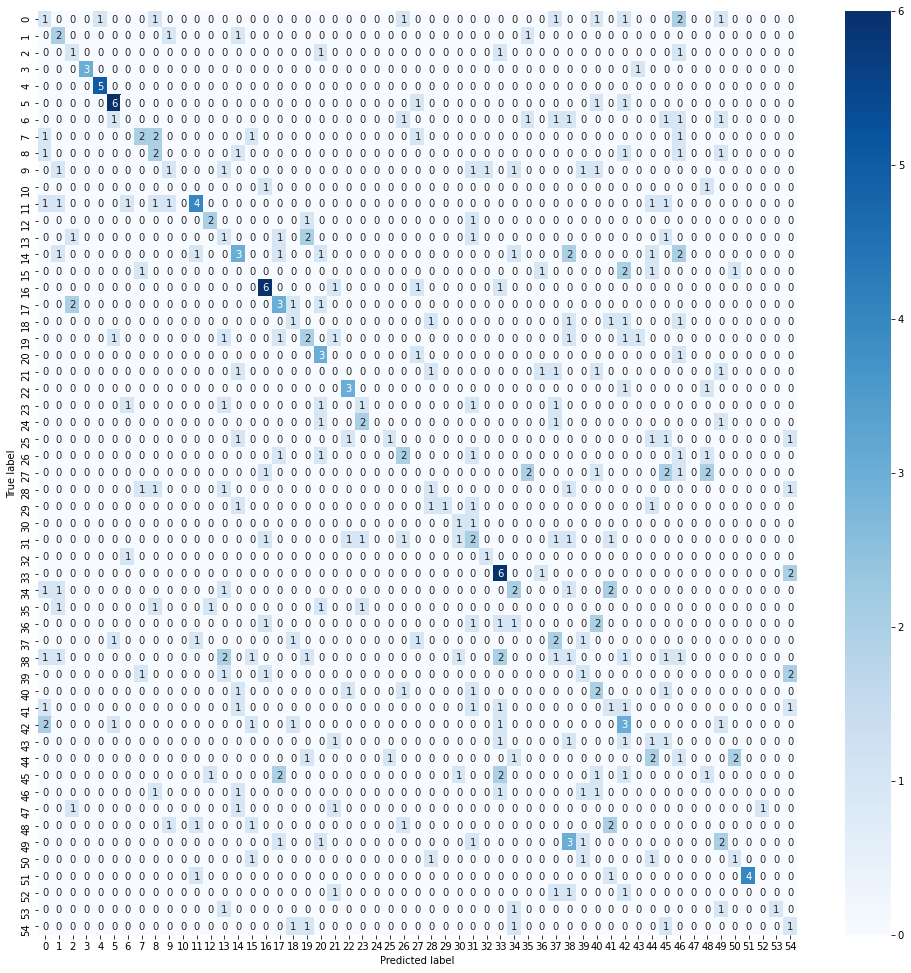

In [ ]:
CHAR_CNN_MODEL_METRIC = NN_metrics_plot(model = char_CNNmodel,to_pred=test_padded_char,true=y_test_encoded,unencoded_true_X=X_test,unencoded_true_y = y_test)

## Hybrid Model


### Model Preperation and **training**

In [ ]:
train_padded.shape[1]

6

In [ ]:
tf.keras.backend.clear_session()
char_input_layer = Input(shape=(train_padded_char.shape[1],),name='INPUT1')
word_input_layer = Input(shape=(train_padded.shape[1],),name='INPUT2')

char_embedding = Embedding(input_dim=len(vocabulary_char)+1,output_dim=300,name='CHAR_EMBEDDING')(char_input_layer)
cnn = Conv1D(filters = 12,kernel_size=8,padding='same')(char_embedding)
maxpool_layer = MaxPool1D(pool_size=10,padding='same')(cnn)
char_layer = LSTM(units=100,activation='relu',dropout=0.2, recurrent_dropout=0.2,name='LSTM1',return_sequences=True)(maxpool_layer)
char_layer = LSTM(units=50,activation='relu',dropout=0.2, recurrent_dropout=0.2,name='LSTM2')(char_layer)

word_embedding = Embedding(input_dim=len(vocabulary)+1,output_dim=512,name='WORD_EMBEDDING')(word_input_layer)
word_layer = LSTM(units=100,activation='relu',dropout=0.2, recurrent_dropout=0.2,name='LSTM3',return_sequences=True)(word_embedding)
word_layer = LSTM(units=100,activation='relu',dropout=0.2, recurrent_dropout=0.2,name='LSTM4')(word_layer)


concat_layer = concatenate([char_layer,word_layer])

layer = Dense(128,activation='relu',name='DENSE1')(concat_layer)
layer = Dense(64,activation='relu',name='DENSE2')(layer)
output_layer = Dense(55,activation='softmax',name='DENSE3')(layer)

Fusionmodel = Model(inputs=[char_input_layer,word_input_layer],outputs = output_layer)

Fusionmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])


In [ ]:
Fusionmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT1 (InputLayer)             [(None, 20)]         0                                            
__________________________________________________________________________________________________
CHAR_EMBEDDING (Embedding)      (None, 20, 300)      10800       INPUT1[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 20, 12)       28812       CHAR_EMBEDDING[0][0]             
__________________________________________________________________________________________________
INPUT2 (InputLayer)             [(None, 6)]          0                                            
______________________________________________________________________________________________

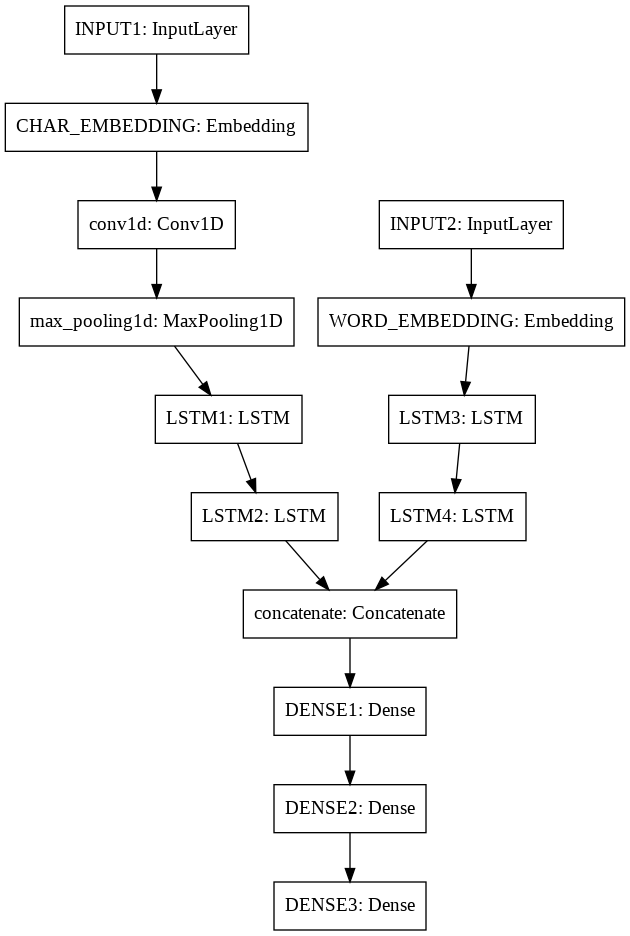

In [ ]:
tf.keras.utils.plot_model(Fusionmodel)

In [ ]:
train = train_padded_char,train_padded

In [ ]:
train_padded_char.shape

(549, 20)

In [ ]:
train_padded.shape

(549, 6)

In [ ]:
Fusionmodel.fit(train,y_train_encoded,validation_split=0.2,verbose=1,epochs=30)

Epoch 1/30
14/14 [==============================] - 18s 319ms/step - loss: 4.0071 - accuracy: 0.0155 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.0059 - val_accuracy: 0.0091 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
14/14 [==============================] - 1s 83ms/step - loss: 3.9977 - accuracy: 0.0265 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.0029 - val_accuracy: 0.0455 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
14/14 [==============================] - 1s 82ms/step - loss: 3.9625 - accuracy: 0.0316 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.0931 - val_accuracy: 0.0455 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/30
14/14 [==============================] - 1s 82ms/step - loss: 3.8291 - accuracy: 0.0748 - f1_m: 0.0000e+00 - precision_m

### Metric plotting

In [ ]:
FUSION_MODEL_METRIC = NN_metrics_plot(model = Fusionmodel,to_pred=[test_padded_char,test_padded],true=y_test_encoded,unencoded_true_X=X_test,unencoded_true_y = y_test)

12/12 [==============================] - 0s 9ms/step - loss: 5.8754 - accuracy: 0.4481 - f1_m: 0.4684 - precision_m: 0.5093 - recall_m: 0.4356
==================== Model metrics ====================
   accuracy  F1_score  precision   recall
0  0.448087  0.468352   0.509264  0.43564


# Deep Learning Model Comparison

In [ ]:
DL_Comparison = pd.DataFrame([ANN_MODEL_METRIC,LSTM_MODEL_METRIC,CNN_MODEL_METRIC,CHAR_CNN_MODEL_METRIC,FUSION_MODEL_METRIC],
                             index = ['BOW with Keras',
                                      'LSTM',
                                      'CNN (word level)',
                                      'CNN (character level)',
                                      'Fusion Model'])
DL_Comparison

,accuracy,F1_score,precision,recall
BOW with Keras,0.710383,0.746353,0.789178,0.708705
LSTM,0.642076,0.668262,0.719808,0.625000
CNN (word level),0.669399,0.699402,0.809582,0.620164
CNN (character level),0.245902,0.256728,0.349283,0.206101
Fusion Model,0.448087,0.468352,0.509264,0.435640


Comparisons

In [ ]:
list_of_metrices = ['accuracy','F1_score','precision','recall']
ML_Comparison = ML_Comparison[list_of_metrices]
ML_Comparison_aug = ML_Comparison_aug[list_of_metrices]
DL_Comparison = DL_Comparison[list_of_metrices]

In [ ]:
pd.concat([ML_Comparison,ML_Comparison_aug,DL_Comparison])

,accuracy,F1_score,precision,recall
Support Vector Classifier,0.767760,0.769863,0.767760,0.767760
Logistic Regression,0.710383,0.720222,0.710383,0.710383
Random Forest,0.672131,0.677686,0.672131,0.672131
Naive Bayes,0.745902,0.747945,0.745902,0.745902
Support Vector Classifier (AUG),0.781421,0.796011,0.834144,0.777085
Logistic Regression (AUG),0.765027,0.767753,0.789339,0.765954
Random Forest (AUG),0.710383,0.728687,0.788760,0.724980
Naive Bayes (AUG),0.737705,0.740475,0.787036,0.758456
BOW with Keras,0.710383,0.746353,0.789178,0.708705
LSTM,0.642076,0.668262,0.719808,0.625000


In [ ]:
FINAL_METRIC = pd.concat([ML_Comparison,ML_Comparison_aug,DL_Comparison])
FINAL_METRIC.sort_values(by='F1_score',ascending=False,inplace=True)

In [ ]:
FINAL_METRIC

,accuracy,F1_score,precision,recall
Support Vector Classifier (AUG),0.781421,0.796011,0.834144,0.777085
Support Vector Classifier,0.767760,0.769863,0.767760,0.767760
Logistic Regression (AUG),0.765027,0.767753,0.789339,0.765954
Naive Bayes,0.745902,0.747945,0.745902,0.745902
BOW with Keras,0.710383,0.746353,0.789178,0.708705
Naive Bayes (AUG),0.737705,0.740475,0.787036,0.758456
Random Forest (AUG),0.710383,0.728687,0.788760,0.724980
Logistic Regression,0.710383,0.720222,0.710383,0.710383
CNN (word level),0.669399,0.699402,0.809582,0.620164
Random Forest,0.672131,0.677686,0.672131,0.672131


In [ ]:
print(f"how much is engine displacement : {predict_check('how much is engine displacement”',SV_clf_aug)}")
print(f"What is the fuel tank capacity? : {('What is the fuel tank capacity?',SV_clf_aug)}")
print(f"I want to know about engine displacement and fuel capacity : {predict_check('I want to know about engine displacement and fuel capacity',SV_clf_aug)}")

how much is engine displacement : engineDisplacement
What is the fuel tank capacity? : fuelCapacity
I want to know about engine displacement and fuel capacity : fuelCapacity


In [ ]:
import joblib

In [ ]:
MODEL_SAVE_PATH = os.path.join('/content/drive/MyDrive/oriserve','classify.sav')
VECTORIZER_SAVE_PATH = os.path.join('/content/drive/MyDrive/oriserve','vect.sav')

In [ ]:
joblib.dump(SV_clf_aug, MODEL_SAVE_PATH)
joblib.dump(tfidf_vect_aug, VECTORIZER_SAVE_PATH)

['/content/drive/MyDrive/oriserve/vect.sav']

###### References:

* Sentiment classification of Hinglish text

* Deep Learning Technique for Sentiment Analysis of Hindi-English Code-Mixed Text Using Late Fusion

* https://www.youtube.com/watch?v=ifPx2IBOWIA

* https://ieeexplore.ieee.org/document/9028928/figures#figures

* https://cs230.stanford.edu/projects_fall_2019/reports/26251423.pdf